C:\Users\Admin\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Admin\AppData\Roaming\Python\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 789ms/step - accuracy: 0.3067 - loss: 2.3098
 Validation accuracy improved to 0.4790
625/625 ━━━━━━━━━━━━━━━━━━━━ 549s 840ms/step - accuracy: 0.3069 - loss: 2.3092 - val_accuracy: 0.4790 - val_loss: 1.4844 - learning_rate: 0.0010
Epoch 2/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 863ms/step - accuracy: 0.4947 - loss: 1.4302
 Validation accuracy improved to 0.5330
625/625 ━━━━━━━━━━━━━━━━━━━━ 570s 913ms/step - accuracy: 0.4948 - loss: 1.4301 - val_accuracy: 0.5330 - val_loss: 1.3562 - learning_rate: 0.0010
Epoch 3/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 817ms/step - accuracy: 0.5872 - loss: 1.1553
 Validation accuracy improved to 0.5660
625/625 ━━━━━━━━━━━━━━━━━━━━ 541s 866ms/step - accuracy: 0.5872 - loss: 1.1552 - val_accuracy: 0.5660 - val_loss: 1.3694 - learning_rate: 0.0010
Epoch 4/30
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 810ms/step - accuracy: 0.6354 - loss: 1.0285
 Validation accuracy improved to 0.6080
625/625 ━━━━━━━━━━━━━━━━━━━━ 537s 859ms/step - accura

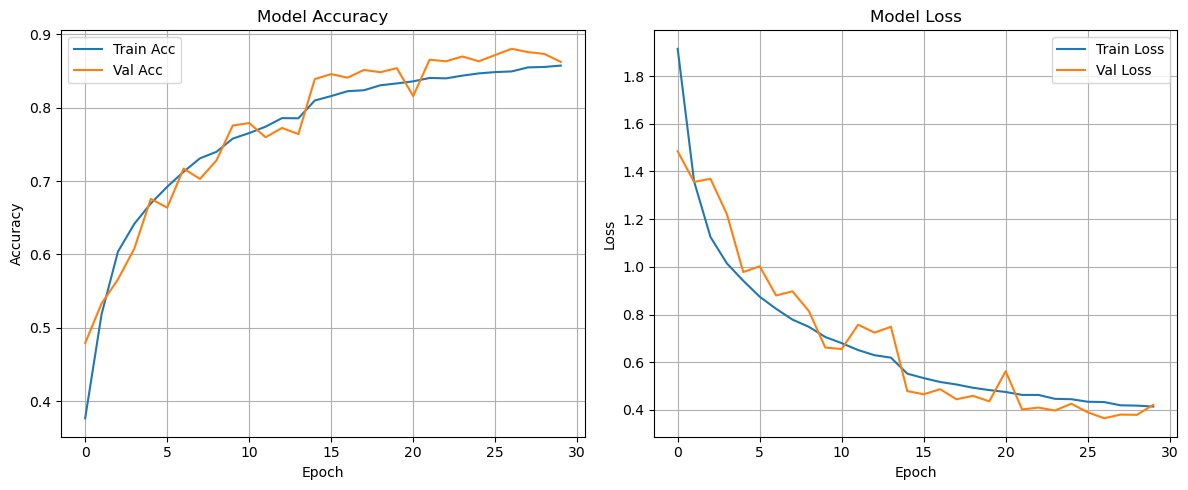

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

# Load CIFAR-10 dataset
(X_train, y_train), (X_test, y_test) = datasets.cifar10.load_data()
X_train, X_test = X_train / 255.0, X_test / 255.0
y_train = y_train.reshape(-1)
y_test = y_test.reshape(-1)

# Train-validation split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Improved CNN model with batchnorm + dropout
def build_improved_model():
    model = models.Sequential()

    #1
    model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu', input_shape=(32, 32, 3)))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.3))

    #2
    model.add(layers.Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.4))

    #3
    model.add(layers.Conv2D(256, (3, 3), padding='same', activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(256, (3, 3), padding='same', activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.5))

    #LastLayer
    model.add(layers.Flatten())
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(10, activation='softmax'))

    return model

model = improved_model()

# Compile with Adam
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

# Track best val accuracy
class TrackBestValAccuracy(tf.keras.callbacks.Callback):
    def __init__(self):
        super(TrackBestValAccuracy, self).__init__()
        self.bestval = 0.0

    def on_epoch_end(self, epoch, logs=None):
        current = logs.get('val_accuracy')
        if current is not None:
            if current > self.bestval:
                self.bestval = current
                print(f"\n Validation accuracy improved to {self.best_val_acc:.4f}")
            else:
                print(f"\n No improvement. Keeping best at {self.best_val_acc:.4f}")

track_best = TrackBestValAccuracy()

# Learning rate scheduler
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

# Data augmentation
datagen = ImageDataGenerator(
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1,
    rotation_range=20,
    zoom_range=0.2,
    shear_range=0.15
)
datagen.fit(X_train)

# Train model
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=64),
    validation_data=(X_val, y_val),
    epochs=30,
    callbacks=[track_best, lr_scheduler]
)

# Evaluate on test data
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"\n Final Test Accuracy: {test_acc:.4f}")

# Plot Accuracy & Loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()
